In [1]:
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import multiprocessing

from dataset import FloorplanSVG
from model import get_model_instance_segmentation
from trainer import Trainer
from config import Config

# Fetch resources

In [2]:
if not os.path.exists('data/cubicasa5k.zip'):
    !gdown 1Jiq9_0UpzJFF8qJlMnGD-TiemaOtc77x -O data/cubicasa5k.zip

In [3]:
if not os.path.exists('data/cubicasa5k/'):
    !unzip -q data/cubicasa5k.zip -d data

# Train

In [4]:
data_folder = 'data/cubicasa5k/'

# train on the GPU or on the CPU, if a GPU is not available
device = Config.DEVICE

# Set the training batch size
bs = 1

# Set the number of worker processes for loading data.
# num_workers = multiprocessing.cpu_count()//2
num_workers = 1

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': False,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': False, # torch.cuda.is_available(),  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'collate_fn': lambda batch: tuple(zip(*batch)),
}

train_data_file = 'train.txt'
train_normal_set = FloorplanSVG(data_folder, train_data_file, max_size=1)
train_data_loader = DataLoader(train_normal_set, **data_loader_params)

valid_data_file = 'val.txt'
valid_normal_set = FloorplanSVG(data_folder, valid_data_file, max_size=1)
valid_data_loader = DataLoader(valid_normal_set, **data_loader_params)

test_data_file = 'test.txt'
test_normal_set = FloorplanSVG(data_folder, test_data_file, max_size=1)
test_data_loader = DataLoader(test_normal_set, **data_loader_params)

In [5]:
# get the model using our helper function
model = get_model_instance_segmentation(Config.NUM_CLASSES)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [6]:
epochs = 5

history = Trainer.train(epochs, model, train_data_loader, valid_data_loader, optimizer, device)

100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


epoch: 1   train_loss:  11.886979103088379   val_loss:  9.856518745422363


100%|██████████| 1/1 [00:08<00:00,  8.22s/it]


epoch: 2   train_loss:  9.212930679321289   val_loss:  3.195694923400879


100%|██████████| 1/1 [00:07<00:00,  7.51s/it]


epoch: 3   train_loss:  2.857656955718994   val_loss:  4.8372111320495605


100%|██████████| 1/1 [00:09<00:00,  9.17s/it]


epoch: 4   train_loss:  9.282649993896484   val_loss:  3.103198528289795


100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


epoch: 5   train_loss:  3.4497742652893066   val_loss:  3.3100242614746094


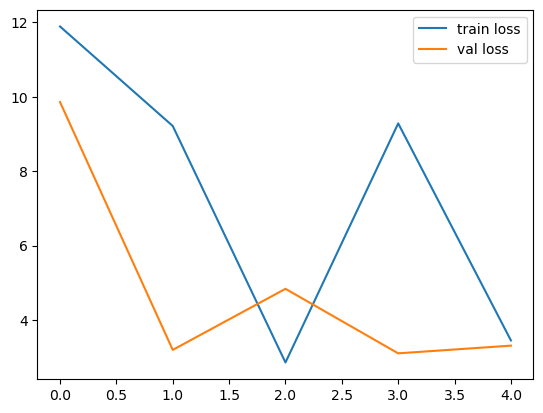

In [7]:
plt.plot(history['train_losses'], label='train loss')
plt.plot(history['val_losses'], label='val loss')
plt.legend()

# Evaluation

In [8]:
from PIL import Image
from torchvision import transforms as T
from matplotlib.patches import Rectangle

model.eval()
img = Image.open("data/cubicasa5k/high_quality_architectural/1191/F1_original.png")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

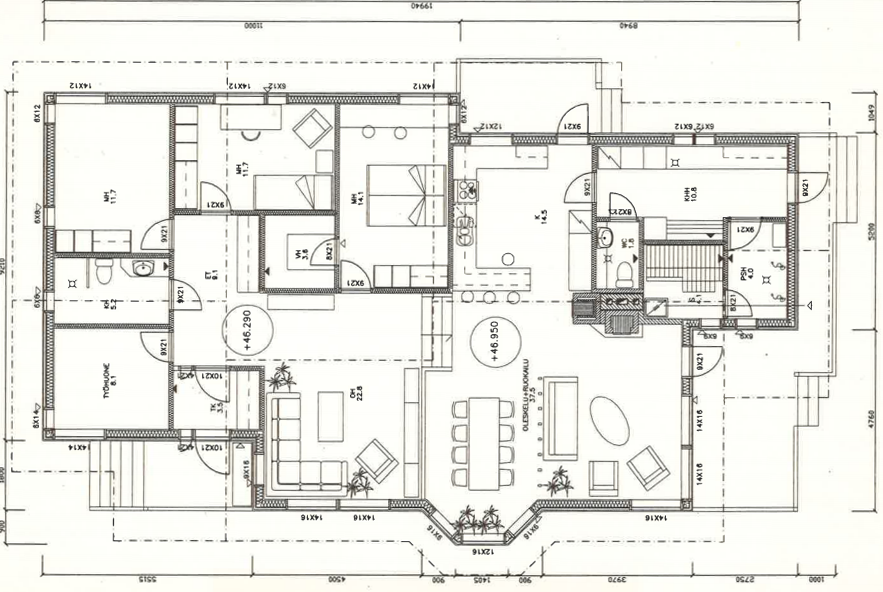

In [9]:
img

In [10]:
wall_class_id = 2

wall_idxs = torch.where(pred[0]['labels'] == wall_class_id)[0].cpu().detach().numpy()
wall_masks = pred[0]['masks'][wall_idxs].cpu().detach().numpy()
wall_boxes = pred[0]['boxes'][wall_idxs].cpu().detach().numpy()
wall_scores = pred[0]['scores'][wall_idxs].cpu().detach().numpy()

print('Number of walls:', len(wall_scores))
print('Wall scores:', wall_scores)

Number of walls: 0
Wall scores: []


In [11]:
plt.imshow((wall_masks[0] * 255).astype("uint8").squeeze())

# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
x = wall_boxes[0][0]
y = wall_boxes[0][1]
width = wall_boxes[0][2] - wall_boxes[0][0]
height = wall_boxes[0][3] - wall_boxes[0][1]
rect = Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
plt.imshow(img)

for box in wall_boxes:
    ax = plt.gca()

    x = box[0]
    y = box[1]
    width = box[2] - box[0]
    height = box[3] - box[1]
    rect = Rectangle((box[0], box[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')

    ax.add_patch(rect)